# Preferential Bayesian Optimisation

A notebook showcasing the use of Preferential Bayesian Optimisation (PBO) [1] for molecular optimisation using preference data elicited from a human chemist.

In [23]:
"""Imports"""

import warnings
warnings.filterwarnings("ignore") # Turn off Graphein warnings

# To import from the GAUCHE package
import sys
sys.path.append('..')

from botorch import fit_gpytorch_model
from botorch.models.pairwise_gp import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood

import gpytorch
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import time
from itertools import combinations

from gauche.dataloader import DataLoaderMP
from gauche.dataloader.data_utils import transform_data
from gauche.kernels.fingerprint_kernels.tanimoto_kernel import TanimotoKernel
from botorch.acquisition.preference import AnalyticExpectedUtilityOfBestOption

In [24]:
"""Utility function for generating ground truth preference data"""

def generate_comparisons(y, n_comp, noise=0.0, replace=False):
    """Function simulating the preferences of a human chemist.
    
    Args:
        y: 1D NumPy array of training data labels
        n_comp: Int indicating the number of pairwise comparisons to generate
        noise: Float indicating the level of noise in the chemist's decisions
        replace: Bool indicating whether to generate comparisons with replacement
    
    Returns:
        comp_pairs: A NumPy array of comparison pairs of the form (m1, m2)
    
    """
    # generate all possible pairs of elements in y
    all_pairs = np.array(list(combinations(range(y.shape[0]), 2)))
    # randomly select n_comp pairs from all_pairs
    comp_pairs = all_pairs[
        np.random.choice(range(len(all_pairs)), n_comp, replace=replace)
    ]
    # add gaussian noise to the latent y values
    c0 = y[comp_pairs[:, 0]] + np.random.standard_normal(len(comp_pairs)) * noise
    c1 = y[comp_pairs[:, 1]] + np.random.standard_normal(len(comp_pairs)) * noise
    reverse_comp = (c0 < c1)
    comp_pairs[reverse_comp, :] = np.flip(comp_pairs[reverse_comp, :], 1)
    comp_pairs = torch.tensor(comp_pairs).long()

    return comp_pairs

In [25]:
"""Utility functions for the Bayesian optimisation loop"""

def initialize_model(train_x, train_comp, state_dict=None):
    """Initialise model and loss function for binary Morgan fingerprints
       using a Tanimoto kernel
       
    Args:
        train_x: Tensor of inputs
        train_obj: Tensor of pairwise comparisons
        state_dict: current_state_dict used to speed up fitting.
        
    Returns: mll object, model object
    """
    
    # Define model for objective
    model = PairwiseGP(train_x, train_comp, covar_module=gpytorch.kernels.ScaleKernel(TanimotoKernel()))
    mll = PairwiseLaplaceMarginalLogLikelihood(model.likelihood, model)
    # load state_dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)
        
    return mll, model

def optimize_acqf_and_get_observation(acq_func, heldout_inputs, heldout_outputs):
    """Optimizes the acquisition function and returns a new candidate and an observation.
    
    Args:
        acq_func: Object representing the acquisition function.
        heldout_inputs: Tensor of heldout inputs
        heldout_outputs: Tensor of heldout outputs.
    Returns:
        new_x, new_obj
    """
    
    # Loop over the discrete set of points to evaluate the acquisition function at:
    acq_vals = []
    for i in range(len(heldout_outputs)):
        acq_vals.append(acq_func(heldout_inputs[i].unsqueeze(-2))) # use unsqueeze to append batch dimension
        
    # Observe new values
    acq_vals = torch.tensor(acq_vals)
    best_idx = torch.argmax(acq_vals)
    new_x = heldout_inputs[best_idx].unsqueeze(-2)  # add batch dimension
    new_obj = heldout_outputs[best_idx].unsqueeze(-1) # add output dimension
    
    # Delete the selected input and value from the heldout set.
    heldout_inputs = torch.cat((heldout_inputs[:best_idx], heldout_inputs[best_idx+1:]), axis=0)
    heldout_outputs = torch.cat((heldout_outputs[:best_idx], heldout_outputs[best_idx+1:]), axis=0)
    
    return new_x, new_obj, heldout_inputs, heldout_outputs

def update_random_observations(best_random, heldout_inputs, heldout_outputs):
    """Simulates a random policy by taking the current list of best values observed randomly, 
       drawing a new random point from the heldout set, observing its value, and updating the list.
       
       Args:
           best_random: List of best random values observed so far
           heldout_inputs: Tensor of inputs
           heldout_outputs: Tensor of output values
           
       Returns:
           best_random, float specifying the objective function value.
    """
    
    # Take a random sample by permuting the indices and selecting the first element
    index = torch.randperm(len(heldout_outputs))[0]
    next_random_best = heldout_outputs[index]
    best_random.append(max(best_random[-1], next_random_best))
    
    # Delete the selected input and value from the heldout set
    heldout_inputs = torch.cat((heldout_inputs[:index], heldout_inputs[index+1:]), axis=0)
    heldout_outputs = torch.cat((heldout_outputs[:index], heldout_outputs[index+1:]), axis=0)
    
    return best_random, heldout_inputs, heldout_outputs

In [26]:
"""Load the dataset and featurise the molecules"""

loader = DataLoaderMP()
loader.load_benchmark("Photoswitch", "../data/property_prediction/photoswitches.csv")

# We use the fragprints representations (a concatenation of Morgan fingerprints and RDKit fragment features)

loader.featurize('fragprints')
X = loader.features
y = loader.labels

In [38]:
"""Preferential Bayesian optimisation loop"""

# Experiment parameters
N_TRIALS = 20
holdout_set_size = 0.75
N_ITERS = 20
NOISE = 0.0
verbose = False
m = 100

best_observed_all_eubo, best_random_all = [], []

# Average over multiple random trials (each trial splits the initial training set for the GP in a random manner)
for trial in range(1, N_TRIALS + 1):
    
    # Set seeds for reproducbibility. Some numerical instability with EUBO for some runs
    torch.manual_seed(trial+10)
    np.random.seed(trial+10)
    
    print(f'\nTrial {trial:>2} of {N_TRIALS}', end="")
    best_observed_eubo, best_random = [], []
    
    # Generate initial training data and initialize model
    train_x_eubo, heldout_x_eubo, train_y_eubo, heldout_y_eubo = train_test_split(X, y, test_size=holdout_set_size, random_state=trial)
    best_observed_value_eubo = torch.tensor(np.max(train_y_eubo))
    # Set the previous winner for the first round
    previous_winner = torch.tensor(train_x_eubo[np.argmax(train_y_eubo)]).unsqueeze(-2)
    
    # Convert numpy arrays to PyTorch tensors and flatten the label vectors
    train_x_eubo = torch.tensor(train_x_eubo.astype(np.float64))
    heldout_x_eubo = torch.tensor(heldout_x_eubo.astype(np.float64))
    train_y_eubo = torch.tensor(train_y_eubo.astype(np.float64))
    heldout_y_eubo = torch.tensor(heldout_y_eubo.astype(np.float64))
    train_comp = generate_comparisons(train_y_eubo.squeeze(-1), m, noise=NOISE)
    
    # The initial heldout set is the same for random search
    heldout_x_random = heldout_x_eubo
    heldout_y_random = heldout_y_eubo
    
    mll_eubo, model_eubo = initialize_model(train_x_eubo, train_comp)
    
    best_observed_eubo.append(best_observed_value_eubo)
    best_random.append(best_observed_value_eubo)
    
    # run N_ITERS rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_ITERS + 1):
        t0 = time.time()
        
        # fit the model
        fit_gpytorch_model(mll_eubo)
        
        # Use EUBO acquisition function
        acq_func = AnalyticExpectedUtilityOfBestOption(pref_model=model_eubo, previous_winner=previous_winner)
        
        try:
            new_x_eubo, new_obj_eubo, heldout_x_eubo, heldout_y_eubo = optimize_acqf_and_get_observation(acq_func, heldout_x_eubo, heldout_y_eubo)
        except:
            break
        # Update training points
        train_x_eubo = torch.cat([train_x_eubo, new_x_eubo])
        train_y_eubo = torch.cat([train_y_eubo, new_obj_eubo])
        previous_winner = new_x_eubo
        
        next_comps = generate_comparisons(train_y_eubo.squeeze(-1), n_comp=m, noise=NOISE)
        train_comp = torch.cat([train_comp, next_comps])
        
        # update random search progress
        best_random, heldout_x_random, heldout_y_random = update_random_observations(best_random,
                                                                                     heldout_inputs=heldout_x_random,
                                                                                     heldout_outputs=heldout_y_random)
        
        best_value_eubo = torch.max(new_obj_eubo, best_observed_eubo[-1])
        best_observed_eubo.append(best_value_eubo)
        
        # reinitialise the model so it is ready for fitting on the next iteration
        # use the current state_dict to speed up fitting
        mll_eubo, model_eubo = initialize_model(
            train_x_eubo,
            train_comp,
            model_eubo.state_dict(),
        )
        
        t1 = time.time()
        
        if verbose:
            print(
                f"\nBatch {iteration:>2}: best value (random, qEUBO) = "
                f"({max(best_random):>4.2f}, {best_value_eubo:>4.2f}), "
                f"time = {t1 - t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")
            
    best_observed_all_eubo.append(best_observed_eubo)
    best_random_all.append(best_random)



Trial  1 of 20....................
Trial  2 of 20....................
Trial  3 of 20....................
Trial  4 of 20....................
Trial  5 of 20....................
Trial  6 of 20....................
Trial  7 of 20....................
Trial  8 of 20....................
Trial  9 of 20...................
Trial 10 of 20....................
Trial 11 of 20....................
Trial 12 of 20....................
Trial 13 of 20....................
Trial 14 of 20....................
Trial 15 of 20................
Trial 16 of 20....................
Trial 17 of 20....................
Trial 18 of 20....................
Trial 19 of 20....................
Trial 20 of 20....................

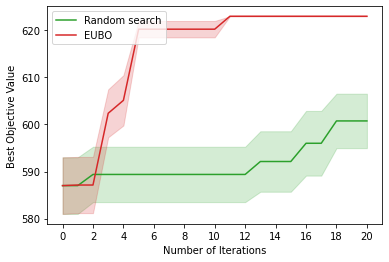

In [41]:
"""Plots the results"""

# Define a confidence interval function for plotting.
def ci(y):
    return 1.0 * y.std(axis=0) / np.sqrt(N_TRIALS)

iters = np.arange(N_ITERS + 1)
# Use first n trials without failure due to numerical errors in EUBO. Can judge from output aboveß
n = 8
y_eubo = torch.tensor(best_observed_all_eubo[0:n])
y_rnd = torch.tensor(best_random_all[0:n])

y_rnd_mean = y_rnd.mean(axis=0)
y_eubo_mean = y_eubo.mean(axis=0)

lower_rnd = y_rnd_mean - ci(y_rnd)
upper_rnd = y_rnd_mean + ci(y_rnd)
lower_eubo = y_eubo_mean - ci(y_eubo)
upper_eubo = y_eubo_mean + ci(y_eubo)

plt.plot(iters, y_rnd_mean, label='Random search', color='tab:green')
plt.fill_between(iters, lower_rnd, upper_rnd, alpha=0.2, color='tab:green')
plt.plot(iters, y_eubo_mean, label='EUBO', color='tab:red')
plt.fill_between(iters, lower_eubo, upper_eubo, alpha=0.2, color='tab:red')
plt.xlabel('Number of Iterations')
plt.ylabel('Best Objective Value')
plt.legend(loc="upper left")
plt.xticks(list(np.arange(0, 21, 2)))
plt.show()